In [1]:
import torch
import torch.optim as optim
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('../src')
from functions.mnist import get_dataloader
from functions.loss import VAELoss
from models.model import ConvVAE

import warnings
warnings.simplefilter('ignore')

## Hyperparameters

In [2]:
batch_size = 64        
epochs = 20           
hidden_size = 784        
latent_size = 200
lr = 0.001

## Device

In [3]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev_name = torch.cuda.get_device_name()
print(f'{dev}: {dev_name}')

cuda: GeForce RTX 2070 with Max-Q Design


## Preprocessing

In [4]:
data_path = '../data/mnist'
transform = transforms.Compose([
    transforms.ToTensor()
])

## Modeling

In [5]:
model = ConvVAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(dev)
train_loader = get_dataloader(data_path, transform)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
losses = []
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(dev)
        
        optimizer.zero_grad()
        
        output, mu, log_var = model(imgs)
        loss = VAELoss(output, imgs, mu, log_var)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print(f"epoch: {epoch+1}/{epochs}, loss: {running_loss}")

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1/20, loss: 11092.010543855777
epoch: 2/20, loss: 7750.639230951826
epoch: 3/20, loss: 7279.905958488806
epoch: 4/20, loss: 7110.167309205924
epoch: 5/20, loss: 7017.499552322095
epoch: 6/20, loss: 6954.239331210854
epoch: 7/20, loss: 6907.252281335371
epoch: 8/20, loss: 6873.022980972648
epoch: 9/20, loss: 6842.519080448761
epoch: 10/20, loss: 6821.071544915629
epoch: 11/20, loss: 6801.344479298541
epoch: 12/20, loss: 6780.763194265142
epoch: 13/20, loss: 6763.203524266225
epoch: 14/20, loss: 6748.183303540195
epoch: 15/20, loss: 6739.579321497285
epoch: 16/20, loss: 6723.6393108571265
epoch: 17/20, loss: 6713.580108317231
epoch: 18/20, loss: 6705.5733921075425
epoch: 19/20, loss: 6698.0280465002
epoch: 20/20, loss: 6689.039736619637


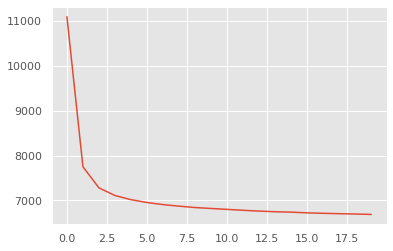

In [7]:
# 学習曲線
plt.style.use("ggplot")
plt.plot(losses)
plt.savefig('../results/losses.png')

In [8]:
data_iter = iter(train_loader)  # イテレータに変換
imgs, _ = data_iter.next()  # 1バッチ目
img_0 = imgs[0]  # 1つ目の画像
img = img_0.permute(1, 2, 0)  # (C, H, W) --> (H, W, C)

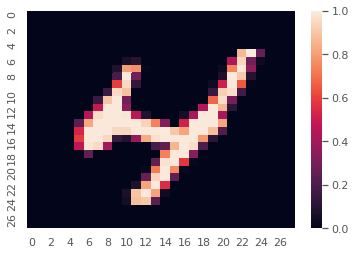

In [9]:
# 入力データ
sns.heatmap(img[:, :, 0])
plt.savefig('../results/input.png')

In [10]:
X, mu, log_var = model(imgs.to(dev))
Z = model._reparameterize(mu, log_var)
Z = model.fc(Z)
x_en = Z.view(Z.size(0), 16, 7, 7)
x_en = x_en[0].permute(1, 2, 0)

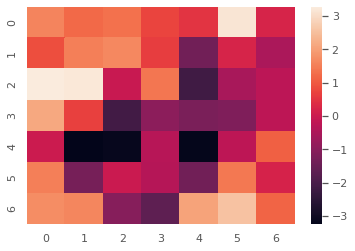

In [11]:
# 潜在空間
sns.heatmap(x_en[:, :, 0].detach().to("cpu"))
plt.savefig('../results/input_encoded.png')

In [12]:
x_hat = X[0]

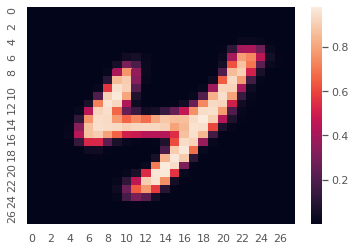

In [13]:
# 再構成後
sns.heatmap(x_hat.permute(1, 2, 0).detach().to("cpu")[:, :, 0])
plt.savefig('../results/output.png')

In [14]:
"""Netron
input_names = ["input"]
output_names = ["output"]
output_dir = "../results/model.onnx"
imgs = imgs.to(dev)
torch.onnx.export(
    model, imgs, output_dir, 
    input_names=input_names,
    output_names=output_names
)
"""

'Netron\ninput_names = ["input"]\noutput_names = ["output"]\noutput_dir = "../results/model.onnx"\nimgs = imgs.to(dev)\ntorch.onnx.export(\n    model, imgs, output_dir, \n    input_names=input_names,\n    output_names=output_names\n)\n'